# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [3]:
type(critics)

pandas.core.frame.DataFrame

In [4]:
critics.fresh.value_counts()

fresh     9482
rotten    6052
none        27
Name: fresh, dtype: int64

In [5]:
(critics.fresh == 'fresh').values.astype(np.int)

array([1, 1, 1, ..., 1, 1, 1])

### Explore

In [6]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


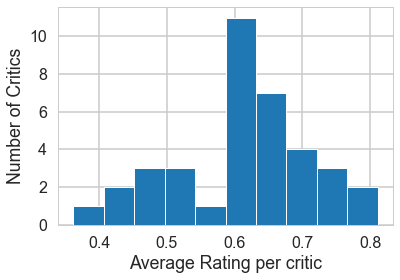

In [7]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [8]:
df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,True,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,True,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,True,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,True,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,True,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [9]:
df.columns

Index(['critic', 'fresh', 'imdb', 'publication', 'quote', 'review_date', 'rtid', 'title'], dtype='object')

In [10]:
print(np.mean(df.fresh))

0.609343872502


<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [12]:
type(x)

numpy.ndarray

In [13]:
x

array([[1, 0, 1, 1],
       [1, 1, 0, 1],
       [3, 0, 0, 0]])

## Sum up columns to get word frequency in corpus
## Need to find way to iterate over columns and increment a sum by 1 if word appears in
## document one or more times. Thus instead of 5 , we get 3 i.e. the word 'hop' appears in 3 documents of the corpus.

In [14]:
print(x.sum(axis=0))

[5 1 1 2]


In [15]:
# https://stackoverflow.com/questions/3797158/counting-non-zero-elements-within-each-row-and-within-each-column-of-a-2d-numpy
columns = (x != 0).sum(0)
columns

array([3, 1, 1, 2])

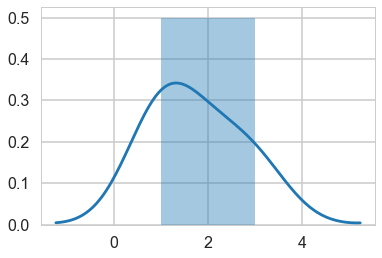

In [16]:
sns.distplot(columns)

(array([ 2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 10 Patch objects>)

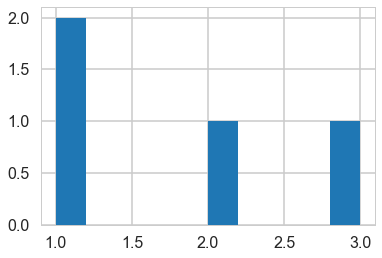

In [17]:
plt.hist(columns)

In [18]:
columns

array([3, 1, 1, 2])

In [19]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = 100*np.arange(1, n+1) / n

    return x, y

In [20]:
x_col, y_col = ecdf(columns)

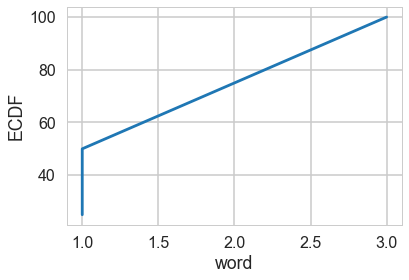

In [21]:
# Generate plot
_ = plt.plot(x_col,y_col,linestyle='-')
# Label the axes
_ = plt.xlabel('word')
_ = plt.ylabel('ECDF')


# Display the plot
plt.show()

In [22]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [23]:
#your turn
# split the data into train & test sets
# First, use function make_xy() to create X,y data
from sklearn.model_selection import train_test_split
X, y = make_xy(critics, vectorizer=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12448, 22417) (12448,)
(3113, 22417) (3113,)


In [24]:
X

<15561x22417 sparse matrix of type '<class 'numpy.int64'>'
	with 272265 stored elements in Compressed Sparse Column format>

In [25]:
# import MultinomialNB()
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
print()
print(clf.predict(X_test))
print()
print(y_test)


[1 1 1 ..., 0 1 1]

[1 1 1 ..., 0 1 1]


In [26]:
print()
print('Accuracy Score for Training set:')
print(clf.score(X_train, y_train))
print()
print('Accuracy Score for Test set:')
print(clf.score(X_test, y_test))
print()


Accuracy Score for Training set:
0.9202281491

Accuracy Score for Test set:
0.788949566335



## Based on scores for training and test data sets, the model is overfitting the training data. Our classifier is in need of modification in order to improve our classification accuracy.

In [27]:
# min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
# min_df = 5 means "ignore terms that appear in less than 5 documents".
#min_df_values = [0.000001,0.00001,0.0001,0.001,0.01,0.05,0.1,0.2,0.5]
min_df_values = range(1,11,1)

In [28]:
scores_df_train = []
scores_df_test = []
for df in min_df_values:
    cv = CountVectorizer(min_df=df) 
    X, y = make_xy(critics, vectorizer=cv)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42) 
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    scores_df_train.append(clf.score(X_train, y_train))
    scores_df_test.append(clf.score(X_test, y_test))

In [29]:
scores_df_train

[0.92022814910025708,
 0.90175128534704374,
 0.88584511568123392,
 0.87467866323907451,
 0.8619858611825193,
 0.85178341902313626,
 0.84535668380462725,
 0.83660025706940877,
 0.83081619537275064,
 0.82438946015424164]

In [30]:
scores_df_test

[0.78894956633472535,
 0.78991326694506903,
 0.78798586572438167,
 0.78734339865081915,
 0.78445229681978801,
 0.78220366206231928,
 0.78027626084163182,
 0.77963379376806941,
 0.77449405717956954,
 0.77063925473819461]

In [31]:
print(type(X))

<class 'scipy.sparse.csc.csc_matrix'>


In [32]:
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(critics.quote)


X_critics = vectorizer.fit_transform(critics.quote)
# convert back to a "normal" numpy array
X_critics = X_critics.toarray()
X_critics

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [33]:
#print(vectorizer.get_feature_names())

In [34]:
word_df = (X_critics != 0).sum(0)
word_df

array([ 7,  1, 10, ...,  3,  1,  1])

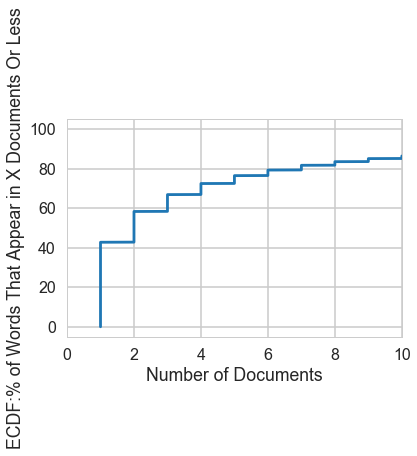

In [35]:
x_word, y_word = ecdf(word_df)

# Generate plot
_ = plt.plot(x_word,y_word,linestyle='-')
# Label the axes
_ = plt.xlabel('Number of Documents')
_ = plt.ylabel('ECDF:% of Words That Appear in X Documents Or Less')
_ = plt.xlim(0,10)

# Display the plot
plt.show()

In [36]:
cv = CountVectorizer(max_df=10) 
X, y = make_xy(critics, vectorizer=cv)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42) 
clf = MultinomialNB()
clf.fit(X_train, y_train)
print('Training Score:')
print(clf.score(X_train, y_train))
print()
print('Testing Score:')
print(clf.score(X_test, y_test))
print()

Training Score:
0.887532133676

Testing Score:
0.669450690652



In [37]:
X

<15561x19365 sparse matrix of type '<class 'numpy.int64'>'
	with 48741 stored elements in Compressed Sparse Column format>

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [38]:
# Your turn.


The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [39]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [40]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [41]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [42]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
hugs = []
best_min_df = 5 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    clf = MultinomialNB(alpha=alpha)
    hug = cv_score(clf, X, y,log_likelihood)
    hugs.append(hug)
    print(alpha, hug)
    print()

0.1 -3054.78906908

1 -2102.15306023

5 -1974.60370299

10 -2002.89868667

50 -2067.04503617



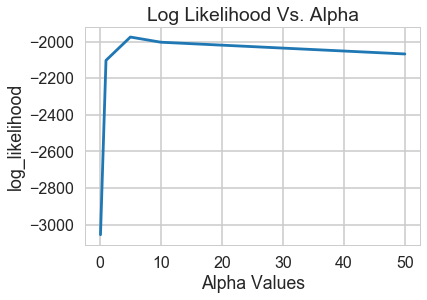

In [43]:
#plt.scatter(alphas, hugs)
plt.plot(alphas,hugs,linestyle='-')
plt.title("Log Likelihood Vs. Alpha")
plt.xlabel('Alpha Values')
plt.ylabel('log_likelihood')

In [44]:
best_alpha = 1
#best_alpha = 0.1
("alpha: {}".format(best_alpha))

'alpha: 1'

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [45]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)
print(best_min_df)
print(best_alpha)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

5
1
Accuracy on training data: 0.907475
Accuracy on test data:     0.738707


In [46]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2687 1567]
 [1279 5359]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [47]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.96
            stunning 0.95
             delight 0.95
            pleasant 0.94
                fire 0.94
            visceral 0.93
              tender 0.93
          mainstream 0.93
             unusual 0.93
            touching 0.92
Bad words	     P(fresh | word)
            tiresome 0.12
        unsatisfying 0.12
      disappointment 0.12
       disappointing 0.12
               hated 0.10
           misguided 0.10
             unfunny 0.10
          ridiculous 0.10
                lame 0.07
               worst 0.06


In [48]:
x = np.eye(xtest.shape[1])
x

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [49]:
x.shape

(6174, 6174)

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

## The method using the identity matrix works by creating a matrix that has a unique word appear only once in a single document in the entire corpus. As a result,this allows calculation of the probability of that sngle word appearing in a 'fresh' review or bad review.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [50]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
After winning a well-deserved Oscar for his role as a high-strung football player in Jerry Maguire, this talented actor has become an intolerable screen presence.

With the exception of Miss Streep's performance, the pleasures of Out of Africa are all peripheral -- David Watkin's photography, the landscapes, the shots of animal life -all of which would fit neatly into a National Geographic layout.

Night Watch works better as a demo reel for the state of Russian effects work than as a first installment in an epic trilogy.

By its midpoint, however, Thornton has begun forcing both the film's poetry and the preternatural goodness of its simple-minded protagonist, and Sling Blade's sweet charms begin to curdle.

The hip, smart yarn has a bite not seen in American movies since The War of the Roses.

Mis-predicted Fresh quotes
--------------------------
Geena Davis and Renny Harlin couldn't cut it with Cutthroat Island. Steven Spielber

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [51]:
#your turn
# A list of new documents
newdocs = ['This movie is not remarkable, touching, or superb in any way']
#newdocs = ['This movie is remarkable, touching, or superb in any way']
#newdocs = ['What I got was something admirable, beautiful, bombastic, but in the way of itself too many times']
# transform the new docs into count-vectorized form
newdocs_counts = vectorizer.transform(newdocs)
newdocs_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [52]:
#prob = clf.predict_proba(newdocs_counts)[:, 0]
#predict = clf.predict(newdocs_counts)
# have classifier make a prediction
prob = clf.predict_proba(newdocs_counts)
pred = clf.predict(newdocs_counts)
print(prob)
print()
print(pred)
print()

[[ 0.01126005  0.98873995]]

[1]



## My classifier incorrectly predicts the review is 'fresh' even though it is not a good review. In this case, the word 'not' negates positive words like 'touching' or 'superb'. Since there are more positive words than negative words, the review was classified as 'fresh'. Another approach  using bigrams could potentially perform better at classifying movie reviews which use the word 'not'. For example, the bigram 'not good' would most likely be associated with bad reviews than 'fresh' reviews. 

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [53]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

# tf-idf

In [54]:
Xtfidf

<15561x22125 sparse matrix of type '<class 'numpy.float64'>'
	with 156947 stored elements in Compressed Sparse Row format>

In [55]:
y = (critics.fresh == 'fresh').values.astype(np.int)
y

array([1, 1, 1, ..., 1, 1, 1])

In [56]:
np.unique(y)

array([0, 1])

In [57]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [6079 9482]


In [58]:
X_train, X_test, y_train, y_test = train_test_split(Xtfidf, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12448, 22125) (12448,)
(3113, 22125) (3113,)


In [59]:
from sklearn.linear_model import LogisticRegression

lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
#Print the accuracy on the test and training dataset
training_accuracy = lr_tfidf.score(X_train, y_train)
test_accuracy = lr_tfidf.score(X_test, y_test)
print()
print('Logistic Regression Classifier Using tf-idf')
print()
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print()


Logistic Regression Classifier Using tf-idf

Accuracy on training data: 0.882069
Accuracy on test data:     0.751365



In [61]:
# Naive Bayes
MNB_tfidf = MultinomialNB(alpha=best_alpha).fit(X_train, y_train)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = MNB_tfidf.score(X_train, y_train)
test_accuracy = MNB_tfidf.score(X_test, y_test)
print('Multinomial Naive Bayes classifier with tf-idf')
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Multinomial Naive Bayes classifier with tf-idf
Accuracy on training data: 0.844714
Accuracy on test data:     0.724382


In [62]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
#Print the accuracy on the test and training dataset
training_accuracy = rf_tfidf.score(X_train, y_train)
test_accuracy = rf_tfidf.score(X_test,y_test)

print()
print('Random Forest Classifier tf-idf')
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print()


Random Forest Classifier tf-idf
Accuracy on training data: 0.989155
Accuracy on test data:     0.714102



## CountVectorizer 

In [64]:
# Your turn
# modify CountVectorizer to include bigrams, trigrams...n-grams
cvec = CountVectorizer(min_df=best_min_df,ngram_range=(1,3))

X, y = make_xy(critics, cvec)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf2 = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#Print the accuracy on the test and training dataset
training_accuracy = clf2.score(xtrain, ytrain)
test_accuracy = clf2.score(xtest, ytest)
print(best_min_df)
print(best_alpha)
print()
print('Multinomial Naive Bayes classifier with CountVectorizer')
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print()

5
1

Multinomial Naive Bayes classifier with CountVectorizer
Accuracy on training data: 0.940673
Accuracy on test data:     0.740176



In [65]:
newdocs = ['This movie is not remarkable, touching, or superb in any way']
# transform the new docs into count-vectorized form
newdocs_counts = cvec.transform(newdocs)
newdocs_counts.toarray()
# predict fresh or not using new classifier with ngram_range(1,3)
prob = clf2.predict_proba(newdocs_counts)
pred = clf2.predict(newdocs_counts)
print(prob)
print()
print(pred)
print()

[[ 0.01247085  0.98752915]]

[1]



In [66]:
feature_names = cvec.get_feature_names()
print(len(feature_names))
print()

14748



In [67]:
feature_names[750:850]

['and low',
 'and made',
 'and magic',
 'and make',
 'and makes',
 'and making',
 'and many',
 'and many of',
 'and michael',
 'and mind',
 'and miss',
 'and moral',
 'and more',
 'and most',
 'and mostly',
 'and mouse',
 'and moving',
 'and mr',
 'and mrs',
 'and much',
 'and murder',
 'and music',
 'and narrative',
 'and never',
 'and never lets',
 'and new',
 'and no',
 'and none',
 'and not',
 'and nothing',
 'and obvious',
 'and occasionally',
 'and oddly',
 'and of',
 'and off',
 'and offers',
 'and often',
 'and old',
 'and on',
 'and on the',
 'and one',
 'and one of',
 'and only',
 'and original',
 'and other',
 'and others',
 'and otherwise',
 'and our',
 'and out',
 'and out of',
 'and over',
 'and passion',
 'and pathos',
 'and performances',
 'and perhaps',
 'and personal',
 'and persuasive',
 'and physical',
 'and place',
 'and plays',
 'and plot',
 'and poignancy',
 'and pointless',
 'and political',
 'and powerful',
 'and predictable',
 'and present',
 'and pretty',
 'a

## Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

lr_cvec = LogisticRegression()
lr_cvec.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
#Print the accuracy on the test and training dataset
training_accuracy = lr_cvec.score(xtrain, ytrain)
test_accuracy = lr_cvec.score(xtest, ytest)

print()
print('Logistic Regression with CountVectorizer')
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print()


Logistic Regression with CountVectorizer
Accuracy on training data: 0.993789
Accuracy on test data:     0.733382



## Optimize Logistic Regression

In [70]:
#the grid of parameters to search over
Cs = [0.001,0.01, 0.1, 1, 10, 100]

In [71]:
Scores = []

for item in Cs:
    clf = LogisticRegression(C=item)
    clf.fit(xtrain, ytrain)
    Scores.append((clf.score(xtest, ytest)))
    
Scores


[0.61283510833639365,
 0.65470069775982376,
 0.71033786265148735,
 0.73338229893499818,
 0.73035255233198682,
 0.72493573264781486]

## No improvement by optimizing C value for Logistic Regression

## Random Forest Classifier

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf_cvec = RandomForestClassifier(n_estimators=100, max_depth=4)
rf_cvec.fit(xtrain, ytrain)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
#Print the accuracy on the test and training dataset
training_accuracy = rf_cvec.score(xtrain, ytrain)
test_accuracy = rf_cvec.score(xtest, ytest)

print()
print('Random Forest Classifier with CountVectorizer')
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print()


Random Forest Classifier with CountVectorizer
Accuracy on training data: 0.609124
Accuracy on test data:     0.609438



## LDA

In [74]:
#lda_vect = CountVectorizer(max_features = 10000, max_df= .15)
lda_vect = CountVectorizer(ngram_range=(1,3))
X = lda_vect.fit_transform(critics.quote)

In [75]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics = 10,learning_method ="batch",max_iter=25,random_state=0)
# build the model and transform the data in one step
reviews_topics = lda.fit_transform(X)

/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [76]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 407793)


In [77]:
reviews_topics[12]

array([ 0.0040005 ,  0.0040009 ,  0.00400063,  0.96399256,  0.00400076,
        0.00400082,  0.00400113,  0.00400063,  0.00400143,  0.00400065])

In [78]:
type(reviews_topics)

numpy.ndarray

In [79]:
len(reviews_topics)

15561

In [80]:
for topic in reviews_topics:
    print(topic)
    print()

[ 0.00142871  0.98714121  0.00142874  0.0014287   0.0014288   0.00142875
  0.00142877  0.0014287   0.00142883  0.0014288 ]

[ 0.00769316  0.00769321  0.18827907  0.00769272  0.0076933   0.00769289
  0.00769367  0.00769319  0.75017562  0.00769318]

[ 0.00294168  0.79475484  0.00294149  0.00294163  0.00294173  0.00294174
  0.00294161  0.00294167  0.18171184  0.00294177]

[ 0.00217415  0.00217429  0.00217405  0.0021741   0.00217417  0.98043237
  0.00217425  0.00217413  0.00217426  0.00217424]

[ 0.00250021  0.00250014  0.00250011  0.00250018  0.00250022  0.00250019
  0.97749817  0.00250022  0.00250031  0.00250024]

[  8.92947524e-04   8.92955632e-04   8.92925442e-04   8.92920994e-04
   8.92945954e-04   8.92959710e-04   9.91963404e-01   8.92945153e-04
   8.92994086e-04   8.93001629e-04]

[ 0.00121965  0.98902306  0.00121962  0.00121962  0.00121965  0.00121966
  0.00121968  0.00121966  0.00121973  0.00121967]

[ 0.00142871  0.00142878  0.00142868  0.0014287   0.00142871  0.00142882
  0.0014

[ 0.00294227  0.00294149  0.00294127  0.00294129  0.00294153  0.0029414
  0.00294149  0.00294167  0.97352609  0.0029415 ]

[  9.17523053e-04   9.17547701e-04   9.17482086e-04   9.17475563e-04
   9.17505247e-04   9.17522314e-04   9.91742397e-01   9.17505452e-04
   9.17523204e-04   9.17518867e-04]

[ 0.00294143  0.97352701  0.00294135  0.0029414   0.00294139  0.00294141
  0.0029415   0.00294158  0.00294149  0.00294145]

[ 0.00121983  0.00121963  0.00121958  0.00121962  0.00121968  0.00121965
  0.0012197   0.00121964  0.98902303  0.00121965]

[ 0.00204117  0.00204097  0.00204094  0.0020409   0.00204102  0.98163089
  0.00204096  0.00204104  0.00204109  0.00204101]

[  8.92923550e-04   8.92930087e-04   8.92899744e-04   8.92904700e-04
   8.92915710e-04   8.92918933e-04   8.92936562e-04   8.92928538e-04
   9.91963714e-01   8.92927833e-04]

[ 0.00769263  0.00769277  0.00769249  0.00769246  0.00769252  0.9307662
  0.00769268  0.00769263  0.00769274  0.00769289]

[ 0.00126596  0.00126597  0.0012

[  9.17547450e-04   9.17535949e-04   9.17488031e-04   9.17525666e-04
   9.17519701e-04   9.17551246e-04   9.17555535e-04   9.17614505e-04
   9.91742109e-01   9.17552865e-04]

[ 0.95262618  0.00526372  0.00526343  0.00526346  0.00526357  0.00526378
  0.00526448  0.00526368  0.0052639   0.00526379]

[ 0.0018183   0.00181852  0.00181831  0.00181845  0.00181837  0.00181835
  0.00181844  0.00181833  0.00181842  0.98363452]

[ 0.00121963  0.00121961  0.00121958  0.0012196   0.00121962  0.00121965
  0.9890233   0.00121968  0.0012197   0.00121963]

[ 0.00400072  0.00400082  0.00400062  0.00400046  0.96399325  0.0040008
  0.00400102  0.00400075  0.00400078  0.00400078]

[ 0.00137004  0.00137003  0.00136999  0.00137     0.9876696   0.00137002
  0.00137002  0.00137005  0.00137014  0.00137011]

[ 0.00270301  0.00270311  0.00270291  0.00270297  0.00270298  0.00270306
  0.97567263  0.00270305  0.00270326  0.00270302]

[ 0.00232583  0.00232595  0.00232571  0.00232572  0.00232593  0.00232586
  0.00232

[ 0.0032262   0.9709646   0.00322606  0.00322596  0.00322633  0.00322609
  0.00322644  0.0032262   0.00322607  0.00322605]

[ 0.98815623  0.00131597  0.00131592  0.00131596  0.00131598  0.001316
  0.00131597  0.00131596  0.00131603  0.00131599]

[ 0.98163024  0.00204106  0.00204097  0.00204104  0.00204111  0.00204108
  0.00204112  0.00204117  0.00204111  0.0020411 ]

[ 0.94374243  0.00625178  0.00625036  0.00625051  0.00625091  0.00625069
  0.00625063  0.00625064  0.00625101  0.00625105]

[ 0.00106396  0.00106398  0.00106389  0.00106395  0.00106397  0.00106393
  0.99042436  0.00106394  0.00106407  0.00106395]

[ 0.00181842  0.00181847  0.00181836  0.00181834  0.0018185   0.00181841
  0.00181845  0.98363378  0.00181874  0.00181852]

[ 0.00250015  0.00250008  0.0025001   0.0025001   0.0025001   0.00250008
  0.00250032  0.00250012  0.97749883  0.00250013]

[ 0.00250031  0.0025004   0.00250037  0.00250035  0.97749567  0.00250048
  0.00250091  0.00250044  0.00250055  0.00250052]

[ 0.001063

[ 0.00131593  0.00131596  0.0013159   0.00131591  0.98815638  0.00131596
  0.001316    0.00131593  0.00131601  0.00131601]

[ 0.00270293  0.00270291  0.00270287  0.00270287  0.00270288  0.00270289
  0.00270289  0.00270322  0.00270303  0.9756735 ]

[ 0.0017243   0.00172429  0.00172422  0.0017242   0.00172427  0.00172428
  0.00172428  0.98448149  0.00172433  0.00172434]

[ 0.00270305  0.00270303  0.00270288  0.002703    0.00270314  0.00270294
  0.97567293  0.00270296  0.00270307  0.002703  ]

[ 0.00204109  0.00204107  0.00204089  0.00204094  0.00204097  0.00204104
  0.00204125  0.00204097  0.9816307   0.00204108]

[ 0.00163959  0.00163962  0.00163943  0.00163949  0.0016395   0.00163953
  0.00163974  0.00163951  0.98524408  0.00163951]

[ 0.00113652  0.00113649  0.00113641  0.00113645  0.00113652  0.0011365
  0.0011366   0.0011365   0.98977153  0.00113649]

[ 0.00156273  0.00156285  0.00156262  0.00156278  0.00156272  0.0015628
  0.98593514  0.00156276  0.00156279  0.00156281]

[ 0.930760

[ 0.00400043  0.0040003   0.00400026  0.96399641  0.00400029  0.0040003
  0.00400043  0.00400038  0.00400068  0.00400051]

[ 0.00113651  0.00113651  0.98977136  0.00113645  0.0011365   0.00113652
  0.00113652  0.00113649  0.00113659  0.00113656]

[ 0.00163941  0.00163943  0.00163941  0.00163942  0.00163941  0.00163943
  0.0016395   0.00163942  0.98524512  0.00163943]

[ 0.00117658  0.0011766   0.00117662  0.00117654  0.00117661  0.00117658
  0.0011766   0.98941065  0.00117664  0.00117659]

[ 0.00149271  0.0014927   0.00149265  0.00149263  0.00149266  0.0014927
  0.00149271  0.00149278  0.00149277  0.98656568]

[ 0.00149273  0.00149279  0.00149262  0.00149268  0.00149273  0.00149272
  0.00149277  0.00149272  0.00149294  0.98656531]

[  9.91742235e-01   9.17532369e-04   9.17492133e-04   9.17491504e-04
   9.17527750e-04   9.17525648e-04   9.17563579e-04   9.17522506e-04
   9.17579924e-04   9.17529740e-04]

[ 0.98902306  0.00121967  0.00121965  0.00121965  0.00121962  0.0012197
  0.0012196


[ 0.00322607  0.00322614  0.0032262   0.00322616  0.00322629  0.00322611
  0.00322621  0.97096424  0.00322634  0.00322623]

[ 0.00142873  0.00142872  0.00142866  0.00142871  0.00142869  0.98714154
  0.00142877  0.00142871  0.00142878  0.0014287 ]

[ 0.00322603  0.00322602  0.00322607  0.00322592  0.00322597  0.00322604
  0.00322609  0.00322605  0.0032262   0.97096561]

[ 0.00137004  0.00137002  0.00136995  0.00136995  0.00137001  0.00136999
  0.00137009  0.98766987  0.00137005  0.00137002]

[ 0.00106397  0.00106402  0.00106393  0.00106394  0.99042417  0.00106398
  0.00106403  0.00106393  0.00106403  0.001064  ]

[ 0.01000077  0.90998963  0.01000072  0.01000066  0.01000181  0.0100009
  0.01000179  0.0100007   0.01000149  0.01000152]

[ 0.00163955  0.0016397   0.00163942  0.00163944  0.00163956  0.0016395
  0.00163955  0.0016395   0.00163957  0.98524421]

[ 0.0011365   0.00113655  0.00113645  0.00113648  0.0011365   0.98977135
  0.00113656  0.00113648  0.00113661  0.00113653]

[ 0.00250

[ 0.0029414   0.97352735  0.00294144  0.00294135  0.00294136  0.00294137
  0.00294137  0.00294137  0.00294163  0.00294136]

[ 0.00131592  0.00131595  0.00131587  0.00131589  0.00131592  0.9881567
  0.00131596  0.0013159   0.00131594  0.00131594]

[ 0.00270328  0.00270311  0.00270285  0.00270289  0.97567269  0.00270292
  0.00270304  0.00270306  0.00270313  0.00270304]

[ 0.00454602  0.00454619  0.00454572  0.00454561  0.00454572  0.00454588
  0.00454616  0.00454596  0.95908692  0.00454583]

[ 0.76308071  0.00097107  0.00097097  0.00097099  0.000971    0.00097109
  0.22915103  0.000971    0.00097111  0.00097104]

[  8.26594193e-04   8.26601472e-04   9.92560595e-01   8.26534112e-04
   8.26619471e-04   8.26579287e-04   8.26674692e-04   8.26550039e-04
   8.26652469e-04   8.26599606e-04]

[ 0.00270324  0.002703    0.00270289  0.00270289  0.0027029   0.00270304
  0.00270307  0.0027029   0.97567307  0.00270301]

[ 0.00121961  0.0012196   0.00121955  0.00121958  0.00121959  0.98902355
  0.00121

[ 0.00142879  0.00142879  0.0014287   0.00142867  0.00142877  0.00142872
  0.0014288   0.0014287   0.00142882  0.98714124]

[ 0.00121966  0.00121967  0.00121962  0.0012196   0.00121964  0.00121965
  0.00121969  0.00121965  0.9890232   0.00121964]

[ 0.00156268  0.00156263  0.00156263  0.00156261  0.00156264  0.00156265
  0.98593622  0.00156261  0.00156266  0.00156266]

[ 0.00113653  0.00113653  0.00113646  0.00113646  0.00113657  0.00113653
  0.00113655  0.9897713   0.00113655  0.00113651]

[ 0.00142872  0.98714161  0.00142865  0.00142866  0.00142871  0.0014287
  0.00142873  0.00142873  0.00142877  0.00142872]

[ 0.00172426  0.00172438  0.00172423  0.0017242   0.00172436  0.00172424
  0.00172439  0.00172423  0.9844814   0.00172429]

[ 0.00357209  0.00357183  0.00357171  0.00357196  0.00357179  0.00357203
  0.00357178  0.96785331  0.00357185  0.00357165]

[ 0.00192326  0.00192326  0.00192322  0.00192323  0.00192334  0.00192329
  0.00192327  0.00192325  0.00192328  0.98269059]

[  9.1755

[ 0.00526412  0.00526415  0.00526365  0.00526383  0.95262488  0.00526366
  0.00526393  0.00526365  0.00526415  0.00526399]

[ 0.97352726  0.00294137  0.00294134  0.00294144  0.00294138  0.0029414
  0.00294154  0.00294135  0.00294144  0.00294148]

[ 0.00142868  0.00142868  0.00142873  0.00142866  0.00142867  0.00142868
  0.98714185  0.00142864  0.00142872  0.00142869]

[ 0.00156264  0.00156262  0.00156263  0.00156259  0.00156266  0.98593625
  0.00156264  0.00156262  0.00156266  0.00156267]

[ 0.00103104  0.00103108  0.001031    0.00103105  0.00103104  0.00103106
  0.99072049  0.00103105  0.00103113  0.00103106]

[ 0.00126597  0.98860628  0.00126592  0.00126592  0.00126594  0.00126602
  0.00126599  0.00126595  0.00126602  0.00126599]

[ 0.00769386  0.00769362  0.0076928   0.00769347  0.00769345  0.93075845
  0.00769452  0.0076928   0.0076937   0.00769333]

[ 0.00454602  0.00454671  0.95908283  0.00454648  0.00454628  0.00454612
  0.00454681  0.00454612  0.00454627  0.00454637]

[ 0.00149

[ 0.00172432  0.00172433  0.00172425  0.00172424  0.00172428  0.00172436
  0.00172437  0.00172432  0.98448121  0.00172433]

[ 0.00149284  0.00149281  0.0014927   0.00149282  0.00149295  0.00149278
  0.00149283  0.98656439  0.001493    0.00149289]

[ 0.00357164  0.00357187  0.00357155  0.00357161  0.00357162  0.00357198
  0.96785455  0.0035718   0.00357172  0.00357166]

[ 0.01000064  0.01000168  0.01000101  0.01000124  0.90998905  0.01000086
  0.01000125  0.01000081  0.01000157  0.0100019 ]

[ 0.0035718   0.00357193  0.00357171  0.00357175  0.96785296  0.00357195
  0.00357203  0.00357183  0.00357199  0.00357205]

[ 0.00400063  0.00400079  0.00400025  0.96399469  0.00400053  0.00400041
  0.00400079  0.00400071  0.00400061  0.00400059]

[ 0.00400049  0.0040005   0.00400029  0.96399572  0.00400046  0.0040005
  0.00400057  0.00400039  0.00400053  0.00400056]

[ 0.0040008   0.00400045  0.00400053  0.00400037  0.00400064  0.00400046
  0.00400066  0.0040004   0.96399508  0.00400062]

[ 0.00454

  0.00156281  0.00156267  0.00156278  0.00156268]

[ 0.00769294  0.00769337  0.00769278  0.00769303  0.00769284  0.00769303
  0.00769319  0.0076928   0.93076306  0.00769297]

[ 0.00131591  0.00131596  0.00131585  0.00131586  0.00131592  0.00131594
  0.00131599  0.00131593  0.00131602  0.98815662]

[ 0.00181837  0.00181841  0.0018183   0.00181833  0.00181863  0.98363433
  0.00181841  0.00181838  0.00181842  0.00181843]

[ 0.00136998  0.00136997  0.00136994  0.00136993  0.00136995  0.00136996
  0.00136996  0.00137002  0.98767024  0.00137003]

[ 0.00142874  0.00142867  0.00142865  0.00142867  0.98714186  0.00142865
  0.0014287   0.00142865  0.00142869  0.00142871]

[ 0.00204102  0.002041    0.00204098  0.00204095  0.00204097  0.00204097
  0.00204105  0.00204092  0.98163112  0.00204102]

[ 0.00270302  0.00270309  0.00270281  0.00270288  0.00270325  0.00270294
  0.00270329  0.00270298  0.00270307  0.97567267]

[ 0.00400051  0.00400098  0.00400035  0.96399337  0.00400085  0.00400056
  0.0040

[ 0.9678536   0.00357181  0.00357161  0.00357169  0.00357172  0.00357166
  0.00357225  0.00357197  0.00357191  0.00357181]

[ 0.98363503  0.00181838  0.00181825  0.00181829  0.00181834  0.00181834
  0.00181836  0.00181835  0.00181835  0.00181831]

[ 0.002703    0.00270293  0.0027029   0.00270282  0.00270289  0.00270289
  0.00270299  0.00270289  0.97567379  0.0027029 ]

[ 0.00142868  0.0014287   0.00142865  0.00142866  0.00142869  0.00142869
  0.00142871  0.00142871  0.98714179  0.00142872]

[ 0.00294163  0.00294157  0.00294157  0.00294183  0.00294161  0.00294153
  0.97352532  0.00294149  0.00294193  0.00294153]

[ 0.00217419  0.00217417  0.00217412  0.00217412  0.00217413  0.00217426
  0.00217429  0.00217414  0.00217422  0.98043238]

[ 0.00181835  0.00181833  0.00181827  0.00181826  0.0018183   0.98363514
  0.00181839  0.00181832  0.00181834  0.0018183 ]

[ 0.97749678  0.00250047  0.00250026  0.00250016  0.00250038  0.00250028
  0.00250039  0.00250039  0.00250058  0.00250032]

[ 0.0013


[ 0.00270312  0.9756724   0.00270288  0.00270295  0.00270304  0.0027031
  0.00270315  0.00270314  0.00270315  0.00270307]

[ 0.00454635  0.95908563  0.00454581  0.00454594  0.00454587  0.00454582
  0.00454663  0.00454571  0.004546    0.00454624]

[ 0.00149276  0.00149284  0.00149265  0.00149266  0.00149274  0.00149283
  0.00149285  0.98656505  0.00149285  0.00149276]

[ 0.0025003   0.00250035  0.00250023  0.00250026  0.00250047  0.00250034
  0.00250036  0.00250031  0.97749702  0.00250037]

[  8.26560810e-04   9.77834141e-01   8.26557160e-04   8.26540062e-04
   8.26570023e-04   8.26620434e-04   8.26611352e-04   8.26795335e-04
   1.55529098e-02   8.26694386e-04]

[  8.47553102e-04   8.47561531e-04   8.47520807e-04   8.47550906e-04
   8.47574625e-04   8.47568134e-04   8.47565642e-04   8.47541200e-04
   9.92371999e-01   8.47564585e-04]

[ 0.0012196   0.00121963  0.00121957  0.00121956  0.98902363  0.00121962
  0.0012196   0.00121959  0.00121962  0.00121959]

[ 0.00526372  0.00526355  0.00


[ 0.00232607  0.00232599  0.97906529  0.00232591  0.00232614  0.00232596
  0.00232607  0.00232603  0.00232647  0.00232606]

[ 0.00232582  0.00232583  0.00232575  0.0023257   0.00232576  0.00232586
  0.00232588  0.97906766  0.00232586  0.00232587]

[ 0.98363464  0.0018184   0.00181831  0.00181835  0.00181833  0.00181837
  0.00181841  0.00181834  0.00181851  0.00181833]

[ 0.0040005   0.00400055  0.00400045  0.96399442  0.00400068  0.0040005
  0.0040009   0.00400048  0.00400085  0.00400067]

[ 0.00769286  0.00769317  0.00769258  0.00769296  0.00769273  0.00769289
  0.00769311  0.0076928   0.93076367  0.00769323]

[ 0.11796768  0.00091764  0.00091754  0.87469137  0.00091764  0.0009176
  0.00091762  0.00091758  0.0009177   0.00091764]

[ 0.00149271  0.0014927   0.00149268  0.00149265  0.0014927   0.00149268
  0.00149272  0.98656571  0.00149272  0.00149274]

[  9.70963360e-04   9.91261149e-01   9.70942029e-04   9.70937371e-04
   9.70955306e-04   9.71009125e-04   9.70990733e-04   9.70967487

  0.00126613  0.00126597  0.00126606  0.00126599]

[ 0.00113654  0.00113656  0.00113645  0.00113653  0.00113657  0.00113651
  0.98977122  0.0011365   0.00113659  0.00113654]

[  9.70984764e-04   9.70970714e-04   9.70930912e-04   9.70936358e-04
   9.70935686e-04   9.70970484e-04   9.91261364e-01   9.70959774e-04
   9.70983995e-04   9.70963523e-04]

[ 0.00137003  0.98766961  0.00136998  0.00136997  0.00137     0.00137006
  0.00137008  0.00137002  0.00137016  0.00137009]

[ 0.001266    0.00126602  0.00126593  0.00126592  0.00126597  0.00126599
  0.00126611  0.00126594  0.00126609  0.98860603]

[ 0.00322622  0.00322608  0.00322617  0.0032261   0.0032262   0.00322608
  0.97096453  0.00322614  0.00322628  0.00322618]

[ 0.00232593  0.00232598  0.00232581  0.0023258   0.00232599  0.00232586
  0.00232599  0.00232584  0.00232607  0.97906672]

[ 0.02500624  0.02500645  0.02500221  0.02500626  0.02500748  0.02500459
  0.02500534  0.77495108  0.02500586  0.02500448]

[  9.43536596e-04   9.43506744

  0.00250021  0.00250016  0.0025002   0.00250025]

[ 0.02500302  0.02500611  0.02500181  0.77496622  0.02500687  0.02500261
  0.02500351  0.0250013   0.02500411  0.02500445]

[ 0.00163955  0.0016395   0.00163952  0.00163949  0.00163956  0.0016395
  0.00163961  0.9852442   0.00163956  0.00163952]

[ 0.00526431  0.00526383  0.0052635   0.0052643   0.00526393  0.00526406
  0.95262394  0.00526442  0.005264    0.00526372]

[ 0.01000061  0.01000097  0.0100015   0.01000154  0.01000051  0.01000029
  0.01000134  0.01000021  0.90999083  0.01000219]

[ 0.00526339  0.0052634   0.00526396  0.00526349  0.0052635   0.00526343
  0.00526367  0.0052638   0.95262746  0.00526389]

[ 0.00400061  0.00400031  0.96399662  0.00400021  0.0040003   0.00400032
  0.00400041  0.00400048  0.0040004   0.00400033]

[ 0.00400083  0.00400087  0.00400074  0.00400043  0.004001    0.96399191
  0.00400086  0.00400062  0.0040008   0.00400195]

[ 0.00232592  0.97906644  0.00232582  0.00232588  0.0023259   0.002326
  0.0023261

  0.00192341  0.00192336  0.0019235   0.00192327]

[ 0.01000249  0.01000217  0.01000542  0.01000141  0.90997453  0.01000234
  0.01000224  0.01000293  0.01000335  0.01000312]

[ 0.0029417   0.00294173  0.00294151  0.00294163  0.00294188  0.00294159
  0.00294185  0.00294153  0.00294191  0.97352467]

[ 0.01000107  0.01000162  0.01000042  0.01000234  0.01000064  0.9099854
  0.01000176  0.01000184  0.01000337  0.01000153]

[ 0.0100011   0.01000207  0.01000132  0.0100015   0.01000176  0.90998434
  0.01000228  0.01000126  0.01000237  0.01000199]

[ 0.00294139  0.00294145  0.00294136  0.0029413   0.0029415   0.00294169
  0.00294148  0.97352696  0.00294149  0.00294138]

[ 0.97352458  0.0029418   0.0029414   0.00294183  0.00294173  0.00294189
  0.00294189  0.00294153  0.00294184  0.0029415 ]

[ 0.00192323  0.00192326  0.00192318  0.00192319  0.00192325  0.98269075
  0.00192329  0.00192324  0.00192337  0.00192324]

[ 0.98815626  0.00131598  0.00131594  0.00131598  0.00131595  0.00131596
  0.00131

  0.00400023  0.00400029  0.00400043  0.96399738]

[ 0.00625074  0.00625094  0.0062506   0.00625062  0.00625086  0.00625055
  0.00625072  0.00625043  0.00625058  0.94374397]

[ 0.00181836  0.00181836  0.00181829  0.00181839  0.00181833  0.98363488
  0.00181837  0.00181831  0.00181837  0.00181835]

[ 0.00270307  0.00270291  0.00270291  0.00270297  0.00270302  0.00270294
  0.00270297  0.00270298  0.00270308  0.97567315]

[ 0.00142869  0.00142874  0.0014287   0.0014287   0.00142871  0.00142868
  0.00142875  0.00142871  0.98714163  0.00142869]

[ 0.00106397  0.00106397  0.00106394  0.00106394  0.00106397  0.00106399
  0.9904242   0.00106404  0.00106398  0.001064  ]

[ 0.0016395   0.00163962  0.00163942  0.00163945  0.0016395   0.0016395
  0.00163957  0.00163947  0.98524435  0.00163963]

[ 0.00142863  0.00142873  0.00142863  0.00142865  0.0014287   0.00142869
  0.00142871  0.00142886  0.98714169  0.00142871]

[ 0.00217408  0.00217417  0.00217404  0.00217401  0.00217408  0.00217409
  0.00217

  0.00137012  0.00136999  0.00137007  0.00137007]

[ 0.00270314  0.00270302  0.00270292  0.00270304  0.00270316  0.00270302
  0.00270306  0.97567203  0.00270351  0.0027031 ]

[ 0.00163961  0.00163975  0.0016395   0.00163949  0.98524337  0.00163963
  0.00163963  0.00163957  0.0016398   0.00163964]

[ 0.0027029   0.00270304  0.00270282  0.00270299  0.00270299  0.00270294
  0.00270293  0.00270296  0.97567346  0.00270298]

[ 0.00100013  0.0010001   0.00100006  0.00100008  0.00100013  0.00100008
  0.99099902  0.00100006  0.00100013  0.0010002 ]

[ 0.00526357  0.00526373  0.00526376  0.0052634   0.00526352  0.00526353
  0.0052638   0.95262706  0.00526405  0.00526359]

[ 0.97096349  0.00322642  0.00322613  0.00322603  0.00322643  0.00322635
  0.00322638  0.00322621  0.00322632  0.00322623]

[ 0.00103103  0.00103105  0.00103103  0.00103101  0.00103104  0.00103109
  0.00103107  0.00103102  0.99072061  0.00103106]

[ 0.00156269  0.00156275  0.00156258  0.00156273  0.00156263  0.00156268
  0.9859

[ 0.00149272  0.00149272  0.00149265  0.00149264  0.00149276  0.00149273
  0.00149272  0.00149271  0.0014928   0.98656556]

[  9.43558922e-04   9.43569748e-04   9.91508033e-01   9.43498616e-04
   9.43503119e-04   9.43521112e-04   9.43592472e-04   9.43541504e-04
   9.43625786e-04   9.43555704e-04]

[ 0.00625059  0.94374289  0.0062505   0.00625032  0.00625083  0.00625079
  0.00625115  0.00625058  0.00625129  0.00625105]

[ 0.00103104  0.00103104  0.00103098  0.00103097  0.00103102  0.00103105
  0.00103103  0.00103103  0.99072083  0.00103102]

[ 0.98767006  0.00137002  0.00136997  0.00136992  0.00136996  0.00137002
  0.00137006  0.00136996  0.00137003  0.00136999]

[ 0.99072062  0.00103103  0.00103099  0.00103099  0.00103107  0.00103101
  0.0010311   0.00103102  0.00103108  0.00103108]

[ 0.00106395  0.00106396  0.00106388  0.00106395  0.00106395  0.00106394
  0.00106402  0.00106398  0.99042435  0.00106402]

[ 0.00322615  0.00322621  0.00322603  0.00322606  0.00322609  0.00322602
  0.0032


[ 0.00163954  0.00163952  0.00163952  0.00163949  0.98524404  0.00163951
  0.00163957  0.00163955  0.00163969  0.00163957]

[ 0.00192333  0.00192342  0.98268935  0.00192329  0.00192343  0.00192344
  0.00192345  0.00192333  0.00192341  0.00192356]

[ 0.0012197   0.00121975  0.00121964  0.57040151  0.00121976  0.00121964
  0.00121972  0.00121964  0.41984091  0.00121973]

[  9.92371604e-01   8.47609745e-04   8.47565411e-04   8.47547246e-04
   8.47616718e-04   8.47632189e-04   8.47632435e-04   8.47568590e-04
   8.47621713e-04   8.47601505e-04]

[ 0.0010991   0.03648815  0.00109898  0.00109905  0.00109907  0.00109911
  0.00109905  0.00109907  0.95471939  0.00109902]

[ 0.00131593  0.98815641  0.00131596  0.00131593  0.00131598  0.00131595
  0.00131597  0.00131592  0.00131598  0.00131596]

[ 0.00163951  0.00163953  0.00163944  0.00163942  0.00163943  0.00163948
  0.98524476  0.00163944  0.0016395   0.00163949]

[ 0.01000186  0.01000137  0.0100022   0.01000059  0.0100006   0.01000146
  0.909

  0.02500075  0.02500625  0.02500454  0.7749722 ]

[ 0.01428837  0.01428732  0.0142875   0.01428736  0.014288    0.87141031
  0.01428849  0.01428678  0.01428863  0.01428724]

[ 0.00400044  0.00400052  0.96399599  0.00400044  0.0040007   0.00400032
  0.00400054  0.00400029  0.00400042  0.00400034]

[ 0.93076157  0.00769322  0.00769262  0.00769296  0.00769371  0.00769281
  0.00769341  0.00769298  0.00769334  0.00769337]

[ 0.00172426  0.00172434  0.00172428  0.00172428  0.00172431  0.00172432
  0.98448129  0.00172429  0.00172433  0.00172429]

[ 0.00526418  0.00526432  0.00526358  0.00526374  0.0052637   0.00526395
  0.00526424  0.95262406  0.00526435  0.00526387]

[ 0.00625022  0.00625042  0.00625033  0.0062501   0.00625032  0.0062507
  0.94374721  0.00625011  0.00625032  0.00625028]

[ 0.01000085  0.01000121  0.01000067  0.01000056  0.90999119  0.01000114
  0.01000124  0.01000076  0.01000121  0.01000118]

[ 0.00126591  0.00126594  0.00126588  0.00126597  0.00126591  0.00126599
  0.00126

In [81]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(reviews_topics, y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12448, 10) (12448,)
(3113, 10) (3113,)


In [83]:
# Logistic regression again
lr_lda = LogisticRegression()
lr_lda.fit(X_train, y_train)
print("Score: {:.2f}".format(lr_lda.score(X_test, y_test)))

Score: 0.61


In [84]:
# Try optimizing Logistic Regression model
#the grid of parameters to search over
Cs = [0.001,0.01, 0.1, 1, 10, 100]

Scores = []

for item in Cs:
    clf = LogisticRegression(C=item)
    clf.fit(X_train, y_train)
    Scores.append((clf.score(X_test, y_test)))
    
Scores

[0.61162865403148092,
 0.61162865403148092,
 0.61162865403148092,
 0.61162865403148092,
 0.61162865403148092,
 0.61162865403148092]

In [85]:
# Naive Bayes
NB_lda = MultinomialNB().fit(X_train, y_train)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = NB_lda.score(X_train, y_train)
test_accuracy = NB_lda.score(X_test, y_test)
print('Multinomial Naive Bayes classifier with LDA')
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Multinomial Naive Bayes classifier with LDA
Accuracy on training data: 0.608772
Accuracy on test data:     0.611629


## No improvement in accuracy score using current LDA approach. 